In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Alpha import Alpha

Part 1. Read data and create alphas (without operations on alphas). Do if you don't have alpha's weights on your local.

In [2]:
# READ DATA

open_df = pd.read_parquet('binance/open.parquet')
close_df = pd.read_parquet('binance/close.parquet')
high_df = pd.read_parquet('binance/high.parquet')
low_df = pd.read_parquet('binance/low.parquet')
vwap_df = pd.read_parquet('binance/vwap.parquet')
buy_volume_df = pd.read_parquet('binance/buy_volume.parquet')
sell_volume_df = pd.read_parquet('binance/sell_volume.parquet')
mo0_buy_count_df = pd.read_parquet('binance/mo0_buy_count.parquet')
mo1_buy_count_df = pd.read_parquet('binance/mo1_buy_count.parquet')
ask_01_size_df = pd.read_parquet('binance/ask_01_size.parquet')
bid_01_size_df = pd.read_parquet('binance/bid_01_size.parquet')

close_df = close_df.ffill(limit=3)
vwap_df = vwap_df.fillna(close_df)

# DROP TICKETS WITH LOST DATA

block_columns = ['AAVEDOWN-USDT', 'BNBDOWN-USDT', 'DOTDOWN-USDT', 'DREP-USDT',
       'ETHDOWN-USDT', 'LINKDOWN-USDT', 'LTCDOWN-USDT', 'LUNA-USDT',
       'SUSHIDOWN-USDT', 'SXPDOWN-USDT', 'TRXDOWN-USDT', 'UNIDOWN-USDT',
       'XLMDOWN-USDT', 'XTZDOWN-USDT', 'YFIDOWN-USDT']

close_df = close_df.drop(block_columns, axis=1) 
vwap_df = vwap_df.drop(block_columns, axis=1) 
buy_volume_df = buy_volume_df.drop(block_columns, axis=1)
sell_volume_df = sell_volume_df.drop(block_columns, axis=1)
ask_01_size_df  = ask_01_size_df.drop(block_columns, axis=1)
bid_01_size_df  = bid_01_size_df.drop(block_columns, axis=1)
mo1_buy_count_df = mo1_buy_count_df.drop(block_columns, axis=1)
mo0_buy_count_df = mo0_buy_count_df.drop(block_columns, axis=1)

# ALPHA FORMULAS

REVERSION_WEIGHTS = - close_df.pct_change()
REVERSION_WEIGHTS.to_parquet("raw_alpha_weights/REVERSION_WEIGHTS.gzip", compression='gzip')

DIRECTED_VOLUME_WEIGHTS = - buy_volume_df / (buy_volume_df + sell_volume_df)
DIRECTED_VOLUME_WEIGHTS.to_parquet("raw_alpha_weights/DIRECTED_VOLUME_WEIGHTS.gzip", compression='gzip')

MO_BUY_COUNT_WEUGHTS = - mo1_buy_count_df / mo0_buy_count_df
MO_BUY_COUNT_WEUGHTS.to_parquet("raw_alpha_weights/MO_BUY_COUNT_WEIGHTS.gzip", compression='gzip')

QUANTILE_01_SIZE_WEIGHTS = - ask_01_size_df / bid_01_size_df
QUANTILE_01_SIZE_WEIGHTS.to_parquet("raw_alpha_weights/QUANTILE_01_SIZE_WEIGHTS.gzip", compression='gzip')

Part 2. Create alpha's objects from local files with raw weights. Operations on alphas. Show metrics.

In [13]:
# CREATE ALPHA OBJECTS

REVERSION_ALPHA = Alpha(
    weights_path = "raw_alpha_weights/REVERSION_WEIGHTS.gzip", 
    close_path = "close_vwap/close.gzip", 
    vwap_path = "close_vwap/vwap.gzip")
REVERSION_ALPHA.truncate_and_normalize(0.05)
REVERSION_ALPHA.decay(15)

DIRECTED_VOLUME_ALPHA = Alpha(
    weights_path = "raw_alpha_weights/DIRECTED_VOLUME_WEIGHTS.gzip", 
    close_path = "close_vwap/close.gzip", 
    vwap_path = "close_vwap/vwap.gzip")
DIRECTED_VOLUME_ALPHA.truncate_and_normalize(0.05)
DIRECTED_VOLUME_ALPHA.decay(9)

MO_BUY_COUNT_ALPHA = Alpha(
    weights_path = "raw_alpha_weights/MO_BUY_COUNT_WEIGHTS.gzip", 
    close_path = "close_vwap/close.gzip", 
    vwap_path = "close_vwap/vwap.gzip")
MO_BUY_COUNT_ALPHA.truncate_and_normalize(0.05)
MO_BUY_COUNT_ALPHA.decay(7)

QUANTILE_01_SIZE_ALPHA = Alpha(
    weights_path = "raw_alpha_weights/QUANTILE_01_SIZE_WEIGHTS.gzip", 
    close_path = "close_vwap/close.gzip", 
    vwap_path = "close_vwap/vwap.gzip")
QUANTILE_01_SIZE_ALPHA.truncate_and_normalize(0.05)
QUANTILE_01_SIZE_ALPHA.decay(9)

In [14]:
# CHOOSE DATE PERIOD

start_period = pd.Timestamp('2021-01-01T00:00:00')
end_period = pd.Timestamp('2022-01-01T00:00:00')

REVERSION_ALPHA.set_reversion_window(window=3)

REVERSION_ALPHA.truncate_by_date_period((start_period, end_period))
DIRECTED_VOLUME_ALPHA.truncate_by_date_period((start_period, end_period))
MO_BUY_COUNT_ALPHA.truncate_by_date_period((start_period, end_period))
QUANTILE_01_SIZE_ALPHA.truncate_by_date_period((start_period, end_period))

REVERSION_ALPHA

Annualized Sharpe Ratio = 10.901412778361395
Daily tvr = 485.032%
Annual return = 2.653%
Max Drawdown = -0.061%
Margin = 0.006%

DIRECTED_VOLUME_ALPHA

Annualized Sharpe Ratio = 10.757081581446082
Daily tvr = 485.173%
Annual return = 0.555%
Max Drawdown = -0.013%
Margin = 0.006%

MO_BUY_COUNT_ALPHA

Annualized Sharpe Ratio = 1.6275119453887539
Daily tvr = 450.909%
Annual return = 0.241%
Max Drawdown = -0.181%
Margin = 0.006%

QUANTILE_01_SIZE_ALPHA

Annualized Sharpe Ratio = 1.8916746929134216
Daily tvr = 475.774%
Annual return = 0.206%
Max Drawdown = -0.173%
Margin = 0.006%



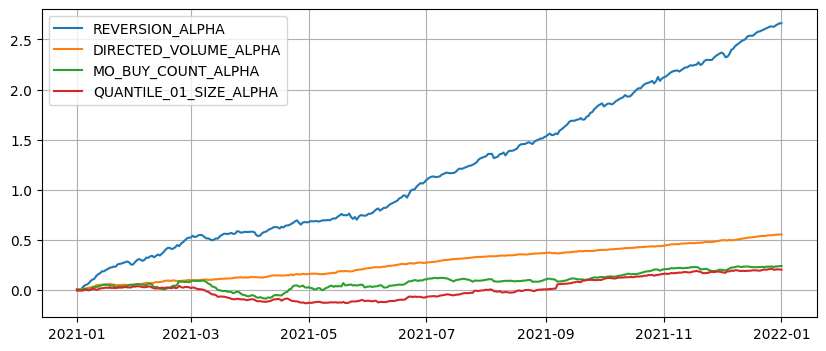

In [15]:
# SHOW METRICS

plt.figure(figsize=(10, 4))

REVERSION_ALPHA.backtest(display=True, label="REVERSION_ALPHA")
DIRECTED_VOLUME_ALPHA.backtest(display=True, label="DIRECTED_VOLUME_ALPHA")
MO_BUY_COUNT_ALPHA.backtest(display=True, label="MO_BUY_COUNT_ALPHA")
QUANTILE_01_SIZE_ALPHA.backtest(display=True, label="QUANTILE_01_SIZE_ALPHA")

plt.legend()
plt.grid()